In [40]:
install.packages("TSA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’, ‘leaps’, ‘locfit’, ‘tseries’




In [42]:
library(TSA)
library(readxl)
df = read_excel("/content/Time-Series-Dataset-University-of-Tehran.xlsx")


Attaching package: ‘TSA’


The following objects are masked from ‘package:stats’:

    acf, arima


The following object is masked from ‘package:utils’:

    tar




In [6]:
head(df)

تاریخ,ساعت,O3 ppb,NO ppb,NO2 ppb,NOx ppb,SO2 ppb,PM 2.5 ug/m3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1399/09/18,0,2.5,208.8,53.5,261.3,8.8,47.5
1399/09/18,1,2.4,213.5,54.2,266.7,9.8,46.1
1399/09/18,2,2.7,244.8,52.9,296.7,7.9,45.0
1399/09/18,3,2.2,233.4,54.7,287.1,8.9,50.8
1399/09/18,4,2.2,212.5,55.3,266.8,8.9,48.1
1399/09/18,5,1.5,164.4,50.5,213.9,4.5,45.1


In [11]:
summary(df)

    تاریخ                ساعت          O3 ppb           NO ppb      
 Length:34373       Min.   : 0.0   Min.   :  0.50   Min.   : -0.40  
 Class :character   1st Qu.: 6.0   1st Qu.:  5.10   1st Qu.:  7.40  
 Mode  :character   Median :11.0   Median : 11.00   Median : 21.70  
                    Mean   :11.5   Mean   : 21.78   Mean   : 47.91  
                    3rd Qu.:18.0   3rd Qu.: 33.20   3rd Qu.: 64.00  
                    Max.   :23.0   Max.   :160.70   Max.   :723.00  
                                   NA's   :2895     NA's   :2285    
    NO2 ppb          NOx ppb          SO2 ppb         PM 2.5 ug/m3   
 Min.   :  2.60   Min.   :  1.70   Min.   : -1.600   Min.   :  0.50  
 1st Qu.: 30.20   1st Qu.: 38.40   1st Qu.:  4.300   1st Qu.: 19.90  
 Median : 49.30   Median : 73.80   Median :  6.400   Median : 29.20  
 Mean   : 51.79   Mean   : 99.08   Mean   :  7.352   Mean   : 36.35  
 3rd Qu.: 68.00   3rd Qu.:132.40   3rd Qu.:  9.100   3rd Qu.: 45.70  
 Max.   :289.80   Max.   :86

We take the "PM 2.5 ug/m3" column as it has the least number of missing values among all colums.

## Preproccessing

We impute the missing values of "PM 2.5 ug/m3" with its' mean.

In [49]:
avg = mean(df$"PM 2.5 ug/m3", na.rm = TRUE)
df$"PM 2.5 ug/m3"[is.na(df$"PM 2.5 ug/m3")] = avg

cat("The number of missing values after imputation:", sum(is.na(df$"PM 2.5 ug/m3")))

The number of missing values after imputation: 0

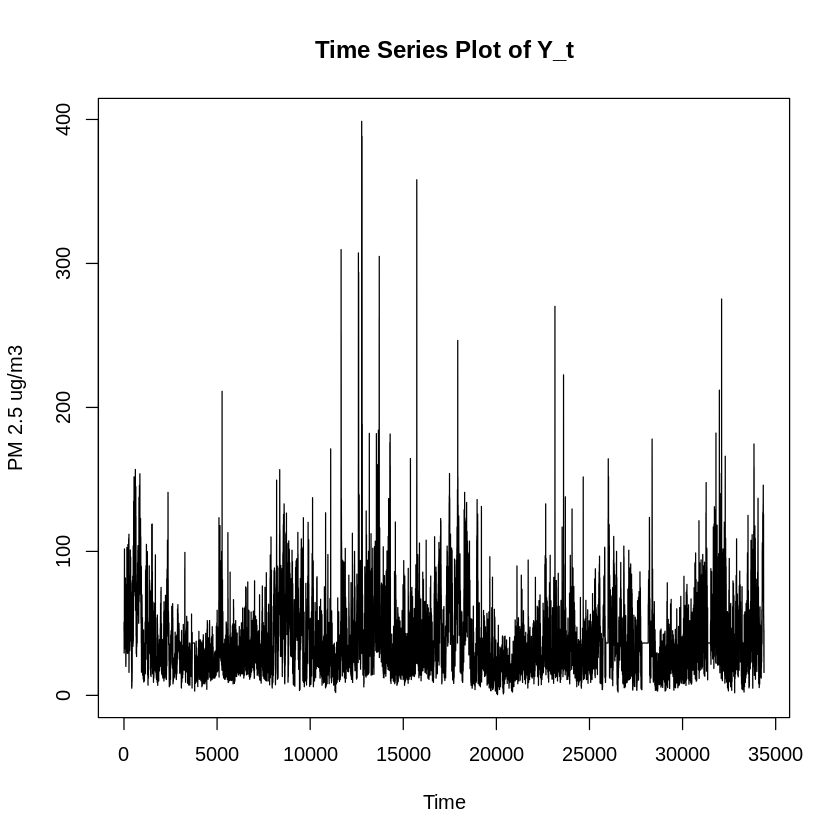

In [62]:
pm_ts = ts(df$"PM 2.5 ug/m3")
plot(pm_ts, ylab = "PM 2.5 ug/m3", main = "Time Series Plot of Y_t")

First we resolve the problem of the variance of serie.

[1] 0.06060606


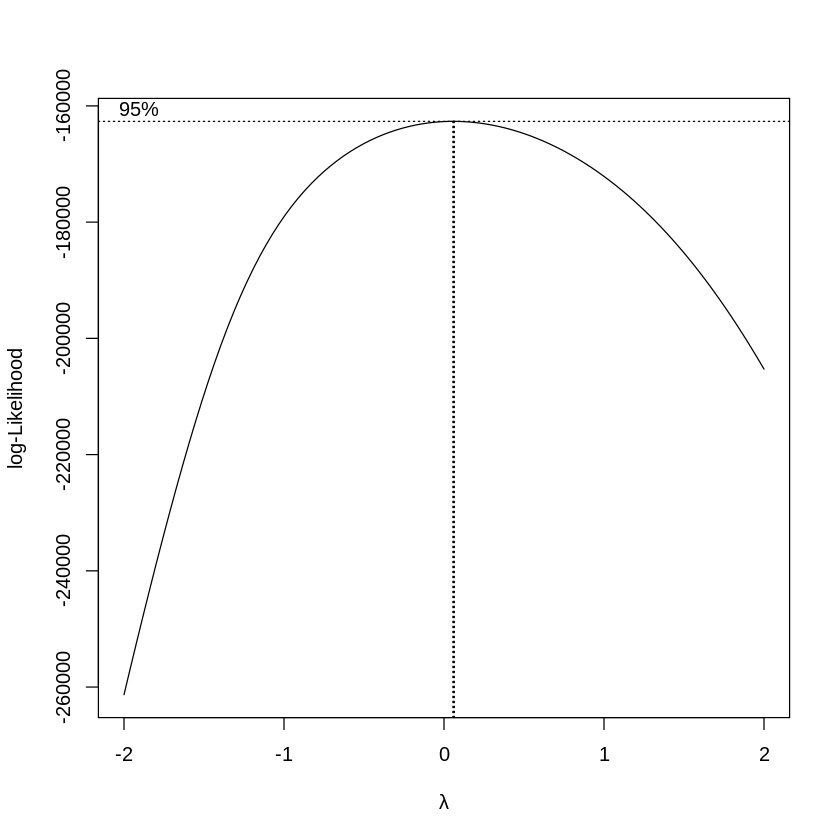

In [56]:
library(MASS)

boxcox_result = boxcox(lm(pm_ts ~ 1), lambda = seq(-2, 2, by = 0.1))

optimal_lambda = boxcox_result$x[which.max(boxcox_result$y)]
print(optimal_lambda)

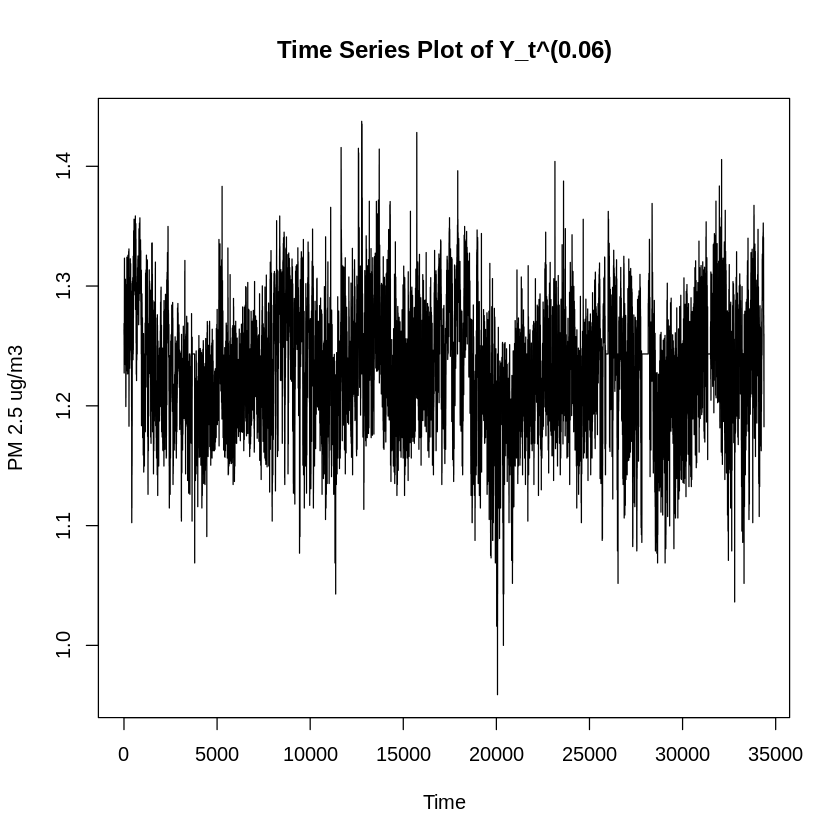

In [63]:
plot(pm_ts^optimal_lambda, ylab = "PM 2.5 ug/m3", main = "Time Series Plot of Y_t^(0.06)")

We can observe that the issue of variance being non-constant is less sensible after box-cox transformation. Now we resolve the issue of the mean of the serie not being constant.

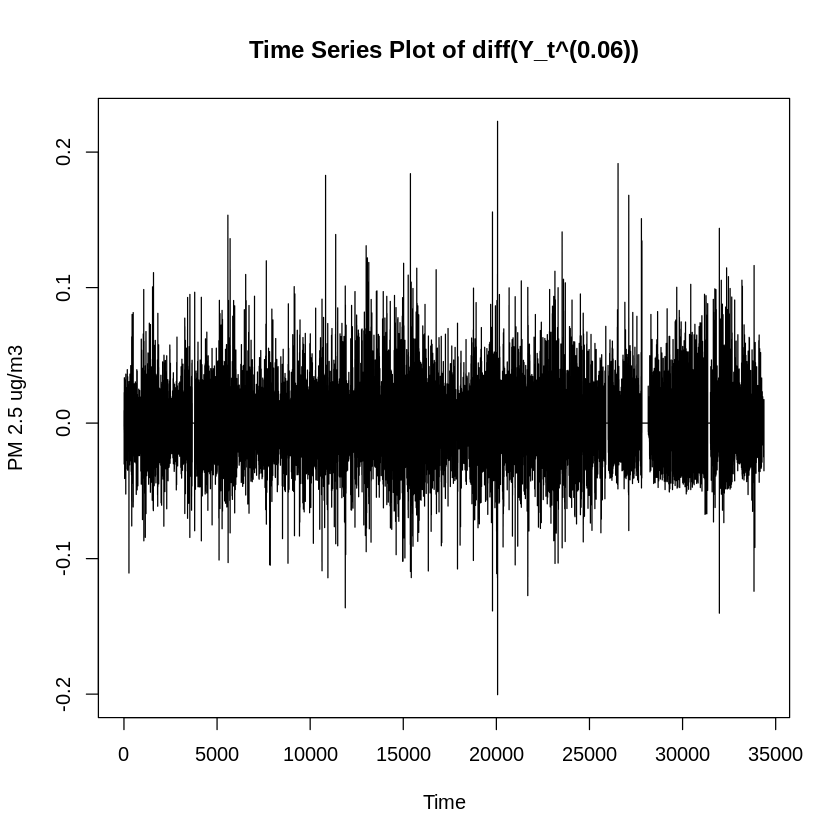

In [72]:
plot(diff(pm_ts^optimal_lambda), ylab = "PM 2.5 ug/m3", main = "Time Series Plot of diff(Y_t^(0.06))")

So our final series is: $\nabla (Y_t^{0.06})$

In [66]:
transformed_ts = diff(pm_ts^optimal_lambda)

## Model Identification

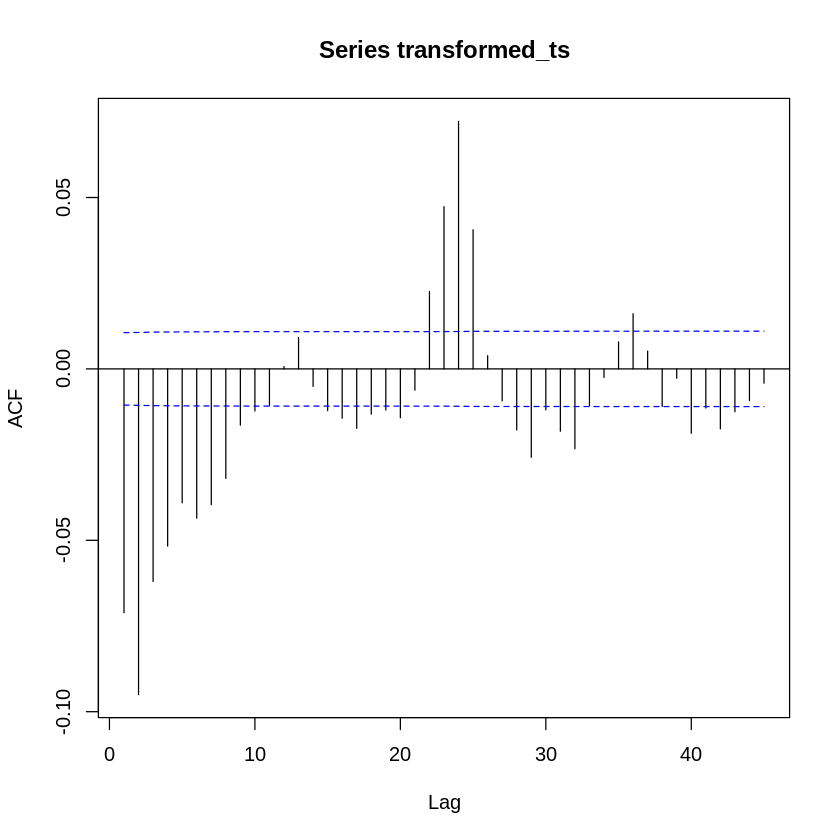

In [69]:
acf(transformed_ts, ci.type = 'ma')

The ACF plot does not look like an ACF from and MA model as the $\rho_i$'s are not tailing off after any specific lag $j$. So we have no candidate MA model.

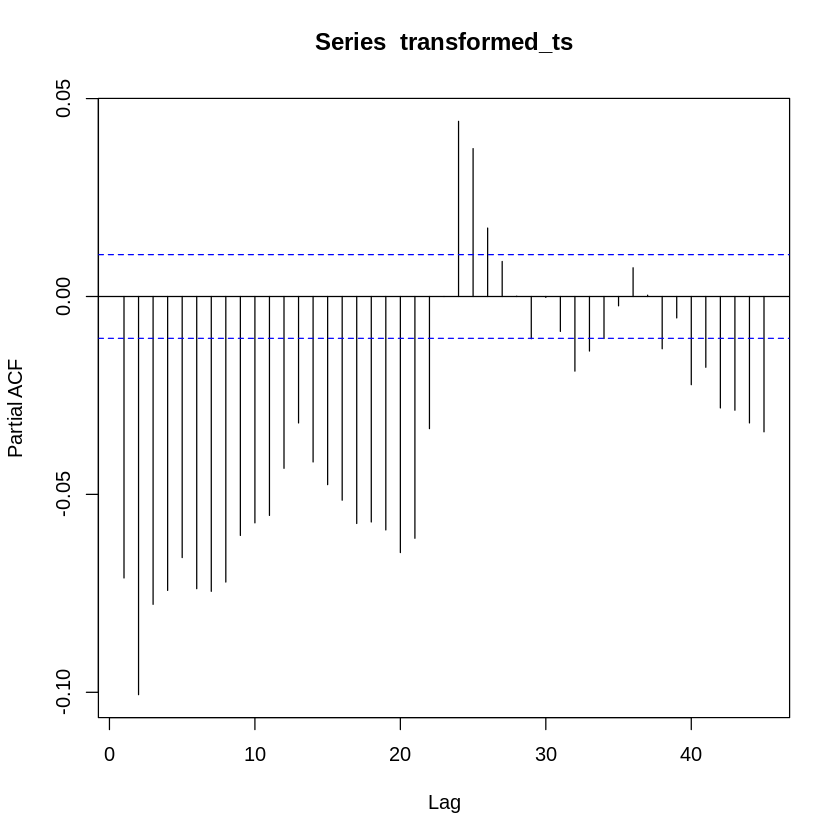

In [70]:
pacf(transformed_ts)

The PACF plot does not look like an ACF from and AR model as the $\phi_{ii}$'s are not tailing off after any specific lag $j$. So we have no candidate AR model.

In [73]:
eacf(transformed_ts)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x x x x x x x x x o  o  o  o 
1 x x o o o o o o o o x  o  o  o 
2 x x o o o o o x o o o  o  o  o 
3 x x o x x o o x o o o  o  o  o 
4 x x x x o o o x o o o  o  o  o 
5 x x x x x o o o o o o  o  o  o 
6 x x x x x x o o o o o  o  x  o 
7 x x x x x x x o o o o  o  x  o 


Based on EACF, we can suggest ARMA(5, 5) and ARMA(2, 8). For further analysis, we look for various subset ARMA models.

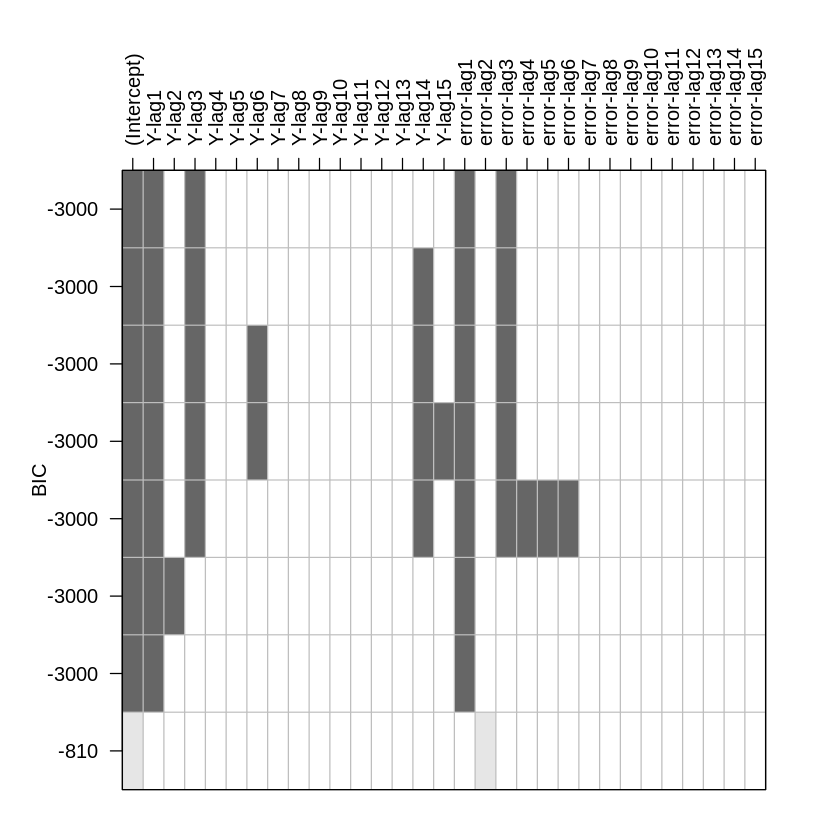

In [78]:
set.seed(123)
res = armasubsets(y = transformed_ts, nar = 15, nma = 15, ar.method = 'ols')
plot(res)

As we are getting similar BICs among these models, we take the model: </br>
$W_t = \theta_0 + \phi_1 W_{t-1} + \phi_3 W_{t-3} + e_t + \theta_1 e_{t-1} + \theta_3 e_{t-3}$ (subset ARMA(3, 3))
</br> where $W_t = \nabla (Y_t^{0.06})$.

## Parameter Estimation

In [113]:
fit1 = arima(transformed_ts, order = c(3, 0, 3), include.mean = FALSE, method = "ML",
            transform.pars = FALSE, fixed = c(NA, 0, NA, NA, 0, NA))
fit1


Call:
arima(x = transformed_ts, order = c(3, 0, 3), include.mean = FALSE, transform.pars = FALSE, 
    fixed = c(NA, 0, NA, NA, 0, NA), method = "ML")

Coefficients:
         ar1  ar2      ar3      ma1  ma2     ma3
      1.1331    0  -0.2308  -1.2703    0  0.2916
s.e.  0.0345    0   0.0215   0.0321    0  0.0298

sigma^2 estimated as 0.0003918:  log likelihood = 86046.28,  aic = -172084.5

In [114]:
fit2 = arima(transformed_ts, order = c(5, 0, 5), include.mean = TRUE, method = "ML")
fit2


Call:
arima(x = transformed_ts, order = c(5, 0, 5), include.mean = TRUE, method = "ML")

Coefficients:
         ar1     ar2     ar3     ar4      ar5      ma1      ma2      ma3
      0.0912  0.3132  0.4512  0.3382  -0.4870  -0.2376  -0.4454  -0.5035
s.e.  0.2424  0.4530  0.5998  0.1694   0.2097   0.2412   0.4517   0.6713
          ma4     ma5  intercept
      -0.3149  0.5686          0
s.e.   0.1829  0.2564          0

sigma^2 estimated as 0.0003918:  log likelihood = 86046.13,  aic = -172070.3

In [115]:
fit3 = arima(transformed_ts, order = c(2, 0, 8), include.mean = FALSE, method = "ML")
fit3


Call:
arima(x = transformed_ts, order = c(2, 0, 8), include.mean = FALSE, method = "ML")

Coefficients:
         ar1     ar2      ma1      ma2      ma3      ma4      ma5      ma6
      0.0722  0.3081  -0.2166  -0.4527  -0.0534  -0.0339  -0.0290  -0.0340
s.e.  0.5233  0.3451   0.5233   0.4201   0.0332   0.0109   0.0127   0.0094
          ma7      ma8
      -0.0310  -0.0185
s.e.   0.0154   0.0088

sigma^2 estimated as 0.0003917:  log likelihood = 86052.86,  aic = -172085.7

In [116]:
resids = rstandard(fit3)

## Residual Analysis

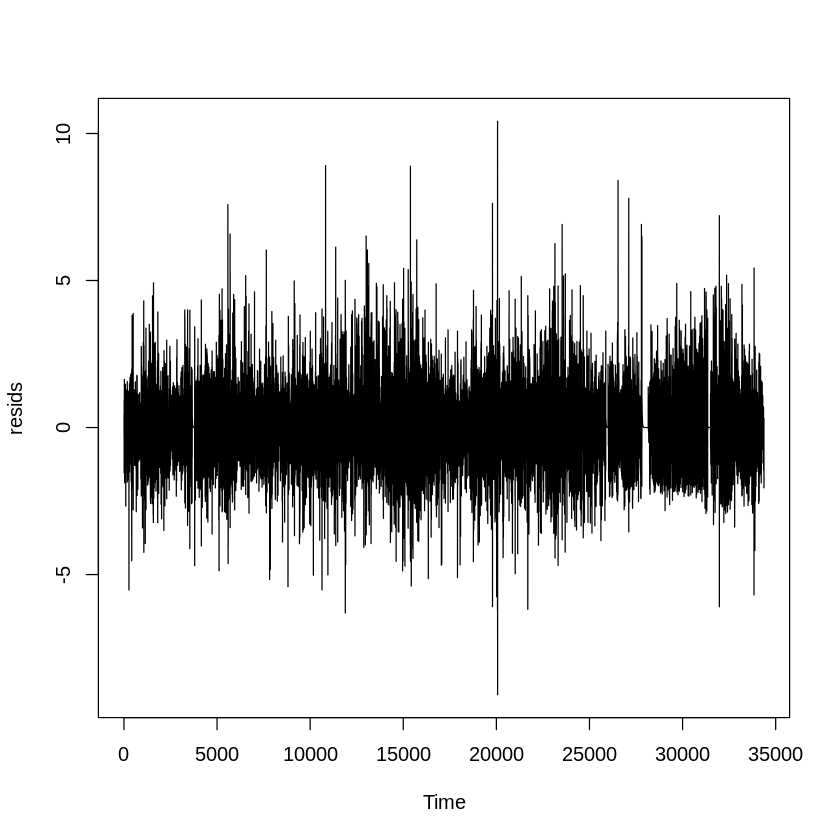

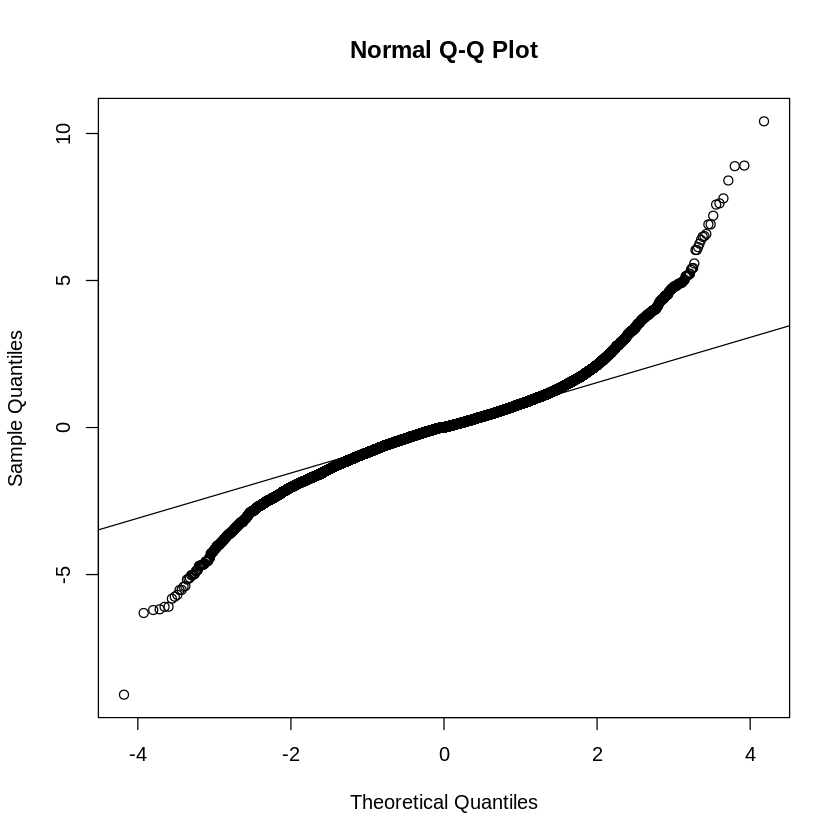

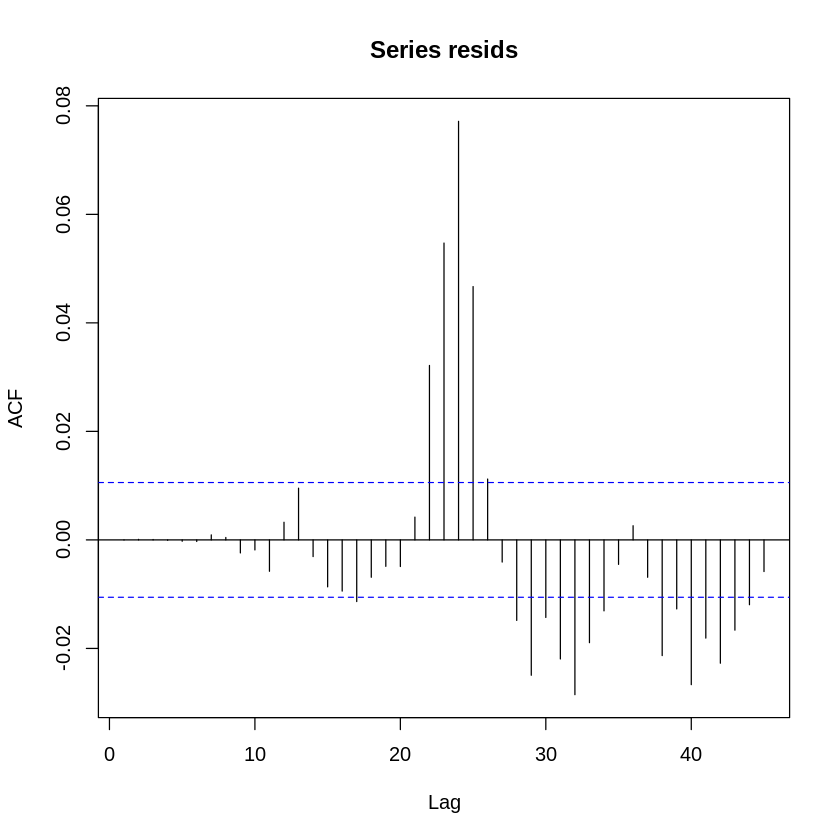

In [117]:
plot(resids)
qqnorm(resids); qqline(resids)
acf(resids)

lol

### Tests for Residuals

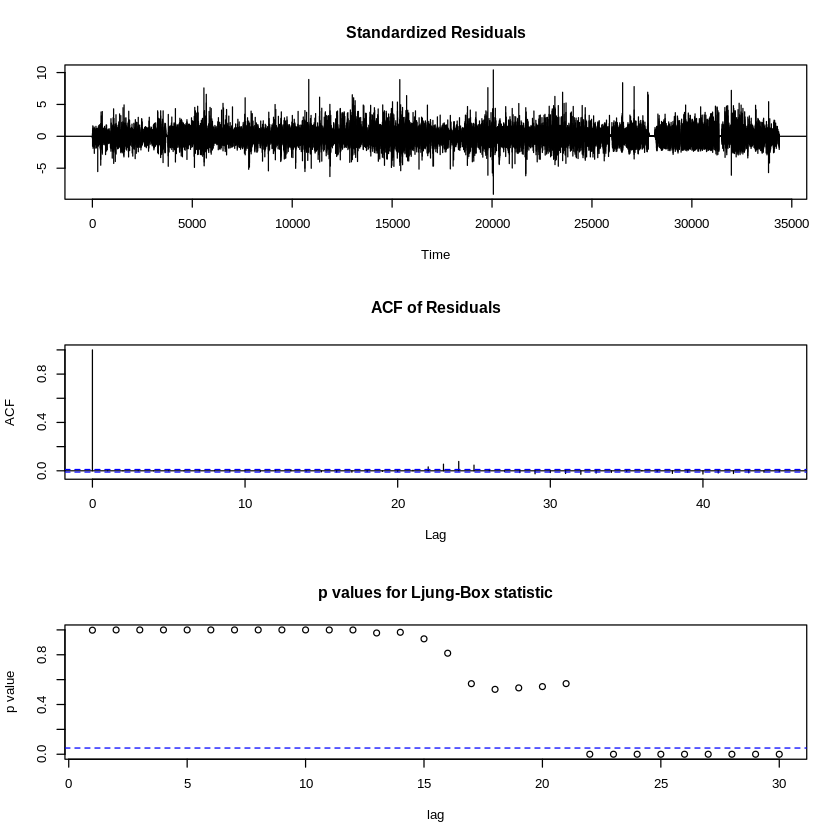

In [121]:
result = tsdiag(fit3, gof = 30, omit.initial = F)

As we can see, the p-values for large enough K's are all small and $H_0: \rho_1=\rho_2=\rho_3=...$ is rejected in these cases.

In [123]:
install.packages("randtests")
library(randtests)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [124]:
runs.test(resids)


	Runs Test

data:  resids
statistic = -18.447, runs = 15477, n1 = 17186, n2 = 17186, n = 34372,
p-value < 2.2e-16
alternative hypothesis: nonrandomness


dard o nefrin. randomness reject shod

In [127]:
shapiro.test(resids)

ERROR: Error in shapiro.test(resids): sample size must be between 3 and 5000


### Kolmogorov Sminrov test

In [128]:
ks.test(resids, pnorm)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  resids
D = 0.056539, p-value < 2.2e-16
alternative hypothesis: two-sided


normality rad shod :)